# Stock Market Sentiment Analysis Using FinBERT
This notebook analyzes stock market sentiment using FinBERT model and proper text processing.

## Setup and Imports
First, let's import all necessary libraries and setup our environment

In [47]:
import os
import requests
from bs4 import BeautifulSoup
from transformers import AutoTokenizer, pipeline
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from tqdm.notebook import tqdm
import nltk
import ssl
import re

## Download NLTK Data
Setup NLTK and download required packages

In [48]:
# Create NLTK data directory
nltk_data_dir = os.path.expanduser("~/nltk_data")
os.makedirs(nltk_data_dir, exist_ok=True)

# Handle SSL issues
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

# Download required NLTK data
for package in ["punkt", "stopwords"]:
    try:
        nltk.data.find(f"tokenizers/{package}")
    except LookupError:
        nltk.download(package, quiet=True)

# Get stopwords
stop_words = set(nltk.corpus.stopwords.words("english"))

## Initialize FinBERT Model
Load the FinBERT model and tokenizer

In [49]:
MODEL_NAME = "yiyanghkust/finbert-tone"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
finbert_sentiment = pipeline(
    "sentiment-analysis", model=MODEL_NAME, tokenizer=tokenizer
)

# Test the model
test_text = "Company reports strong earnings growth"
print("Test sentiment:", finbert_sentiment(test_text))

Device set to use cpu


Test sentiment: [{'label': 'Positive', 'score': 1.0}]


In [50]:
piege = "Despite Tesla's announcement of record-breaking profits this quarter, analysts remain skeptical about its long-term growth."
print("Test sentiment:", finbert_sentiment(piege))

Test sentiment: [{'label': 'Negative', 'score': 0.9999996423721313}]


## Define Text Processing Functions
Setup functions for cleaning and processing text

In [51]:
def clean_text(text):
    """Clean and preprocess text."""
    # Remove special characters and digits
    text = re.sub(r"[^\w\s]", " ", text)
    text = re.sub(r"\d+", " ", text)

    # Convert to lowercase
    text = text.lower()

    # Tokenize into words
    try:
        words = nltk.word_tokenize(text)
    except:
        words = text.split()

    # Remove stopwords and short words
    words = [word for word in words if word not in stop_words and len(word) > 2]

    return " ".join(words)

## Fetch Stock News
Get news data for a specific stock ticker

In [52]:
ticker = "TSLA"  # Example
stock = yf.Ticker(ticker)
news_data = stock.news
print(f"Found {len(news_data)} news articles")

# Show sample news item
print("\nSample news item:")
print(f"Title: {news_data[0]['content']['title']}")
print(f"Source: {news_data[0]['content']['provider']['displayName']}")
print(f"Date: {news_data[0]['content']['pubDate']}")

Found 10 news articles

Sample news item:
Title: Trump's EV, tariff plans bring more uncertainty to an auto industry already in flux
Source: Yahoo Finance
Date: 2025-01-18T15:30:06Z


## Process News Articles
Extract and process the content from each news article

In [53]:
processed_news = []

for news_item in tqdm(news_data):
    # Accéder aux données dans la nouvelle structure
    title = news_item['content']['title']
    date = datetime.strptime(news_item['content']['pubDate'], '%Y-%m-%dT%H:%M:%SZ')
    
    # Process title
    processed_title = clean_text(title)

    try:
        # Utiliser l'URL canonique pour l'article
        article_url = news_item['content']['canonicalUrl']['url']
        response = requests.get(article_url, timeout=10)
        response.raise_for_status()

        soup = BeautifulSoup(response.content, "html.parser")
        paragraphs = (
            soup.find("article").find_all("p")
            if soup.find("article")
            else soup.find_all("p")
        )

        if paragraphs:
            # Join paragraphs and process
            full_text = " ".join(
                p.get_text() for p in paragraphs if p.get_text().strip()
            )
            processed_text = clean_text(f"{title} {full_text}")
        else:
            processed_text = processed_title

    except Exception as e:
        print(f"Error processing article: {str(e)}")
        processed_text = processed_title

    processed_news.append(
        {
            "title": title,
            "date": date,
            "processed_text": processed_text,
            "text_length": len(processed_text.split()),
        }
    )

print(f"\nProcessed {len(processed_news)} articles")

  0%|          | 0/10 [00:00<?, ?it/s]

Error processing article: 403 Client Error: Forbidden for url: https://www.wsj.com/finance/investing/which-trump-trades-workedand-which-very-much-didnt-b123f532?siteid=yhoof2&yptr=yahoo
Error processing article: 403 Client Error: Forbidden for url: https://www.wsj.com/tech/trump-tech-ceos-musk-bezos-zuckerberg-d083f25b?siteid=yhoof2&yptr=yahoo
Error processing article: 403 Client Error: Forbidden for url: https://www.wsj.com/politics/elon-musk-steve-bannon-trump-adviser-influence-e2f7cc4f?siteid=yhoof2&yptr=yahoo
Error processing article: 403 Client Error: Forbidden for url: https://www.wsj.com/politics/policy/trump-deregulation-rule-cutting-plans-26458126?siteid=yhoof2&yptr=yahoo

Processed 10 articles


## Analyze Sentiments
Run sentiment analysis on processed texts

In [54]:
results = []

for item in tqdm(processed_news):
    try:
        # Get sentiment
        sentiment = finbert_sentiment(item["processed_text"][:512])[0]

        results.append(
            {
                "date": item["date"],
                "title": item["title"],
                "sentiment": sentiment["label"],
                "confidence": sentiment["score"],
                "text_length": item["text_length"],
            }
        )
    except Exception as e:
        print(f"Error analyzing sentiment: {str(e)}")
        continue

sentiment_df = pd.DataFrame(results)

# Display results
print("\nSentiment Distribution:")
print(sentiment_df["sentiment"].value_counts())
print("\nAverage Confidence Score:")
print(sentiment_df.groupby("sentiment")["confidence"].mean())

  0%|          | 0/10 [00:00<?, ?it/s]


Sentiment Distribution:
sentiment
Neutral     6
Positive    3
Negative    1
Name: count, dtype: int64

Average Confidence Score:
sentiment
Negative    0.995565
Neutral     0.874617
Positive    0.951146
Name: confidence, dtype: float64


## Visualize Results
Create visualizations to better understand the sentiment analysis

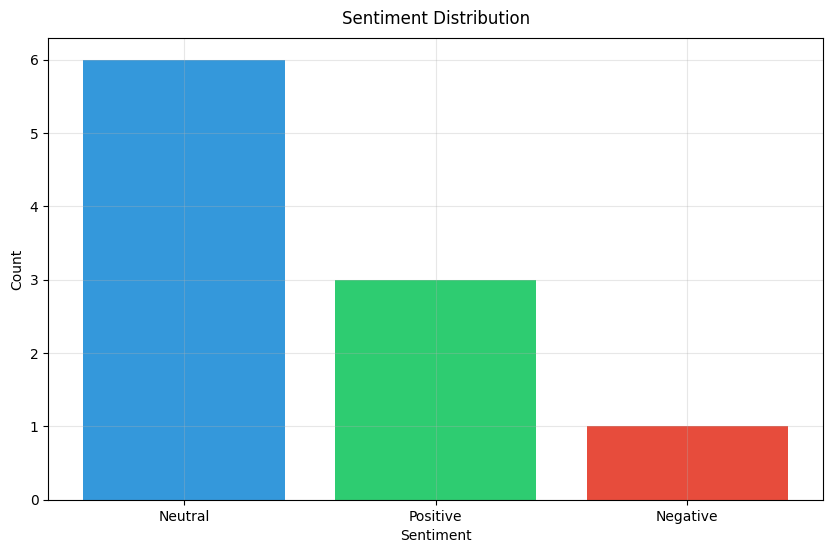

In [55]:
# 1. Sentiment Distribution
plt.figure(figsize=(10, 6))
counts = sentiment_df['sentiment'].value_counts()
colors = {'Positive': '#2ecc71', 'Negative': '#e74c3c', 'Neutral': '#3498db'}
plt.bar(counts.index, counts.values, color=[colors.get(x, '#7f8c8d') for x in counts.index])
plt.title("Sentiment Distribution", fontsize=12, pad=10)
plt.xlabel("Sentiment", fontsize=10)
plt.ylabel("Count", fontsize=10)
plt.grid(True, alpha=0.3)
plt.show()

<Figure size 1000x600 with 0 Axes>

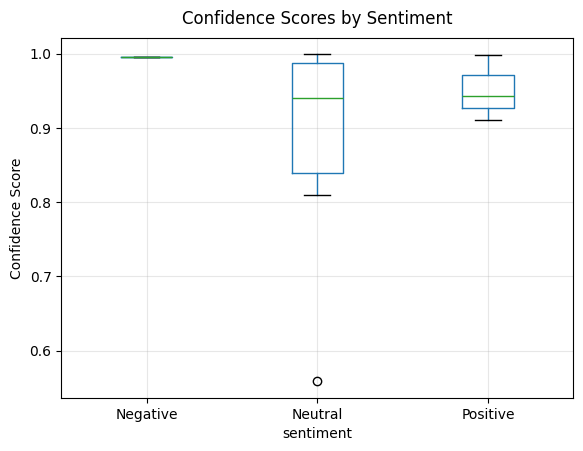

In [56]:
# 2. Confidence by Sentiment
plt.figure(figsize=(10, 6))
sentiment_df.boxplot(column='confidence', by='sentiment')
plt.title("Confidence Scores by Sentiment", fontsize=12, pad=10)
plt.suptitle('')  # Remove automatic suptitle
plt.grid(True, alpha=0.3)
plt.ylabel("Confidence Score", fontsize=10)
plt.show()

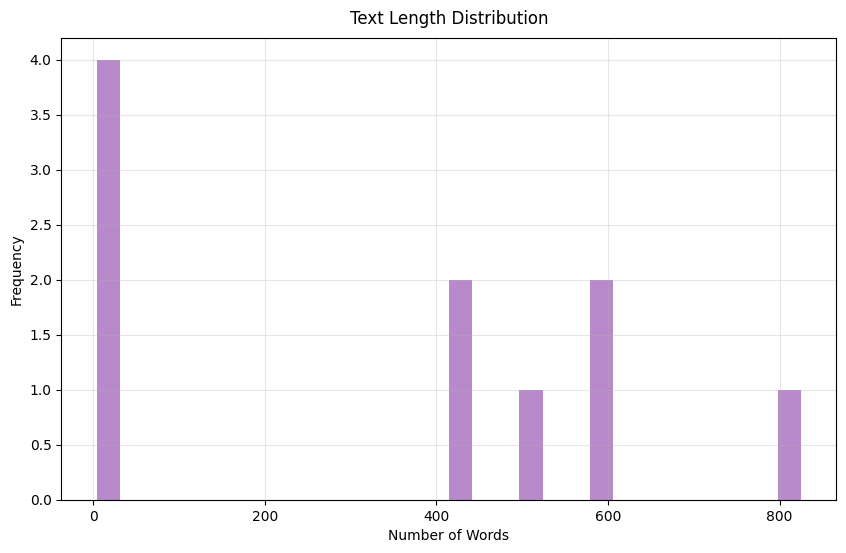

In [57]:
# 3. Text Length Distribution
plt.figure(figsize=(10, 6))
plt.hist(sentiment_df['text_length'], bins=30, color='#9b59b6', alpha=0.7)
plt.title("Text Length Distribution", fontsize=12, pad=10)
plt.xlabel("Number of Words", fontsize=10)
plt.ylabel("Frequency", fontsize=10)
plt.grid(True, alpha=0.3)
plt.show()